In [1]:
from torch.nn import BCEWithLogitsLoss
import torch
import numpy as np
from func.network import VoxResNet, CellSegNet_basic_edge_gated_XIII, CellSegNet_basic_lite_w_groupnorm_deep_supervised_II, CellSegNet_basic_edge_gated_IV
import matplotlib.pyplot as plt
import torch.nn as nn

In [2]:
load_path = 'output/model_HMS_edge_gated_20.pkl'
#load_path = 'output/model_HMS_delete_fake_cells.pkl'

# init model
model=CellSegNet_basic_edge_gated_XIII(input_channel=1, n_classes=3, output_func = "softmax")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

checkpoint = torch.load(load_path)
model.load_state_dict(checkpoint['model_state_dict'], strict=False)

model.eval()

CellSegNet_basic_edge_gated_XIII(
  (conv1): Conv3d(1, 16, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  (conv2): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (bnorm1): GroupNorm(1, 32, eps=1e-05, affine=True)
  (conv3): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
  (resmodule1): ResModule_w_groupnorm(
    (groupnorm_module): GroupNorm(1, 64, eps=1e-05, affine=True)
    (conv_module): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  )
  (conv4): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
  (resmodule2): ResModule_w_groupnorm(
    (groupnorm_module): GroupNorm(1, 64, eps=1e-05, affine=True)
    (conv_module): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  )
  (conv5): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
  (resmodule3): ResModule_w_groupnorm(
    (groupnorm_module): GroupNorm(1, 64, eps=1e-05, affine=T

In [3]:
test_img = np.load("data/CellSeg_dataset/HMS_processed/raw/135.npy")

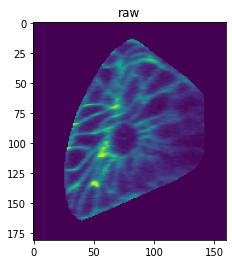

In [4]:
plt.figure()
plt.title("raw")
plt.imshow(test_img[:,150,:])

In [5]:
# test_img_cropped = test_img[60:124, 100:164, 40:104]
test_img_cropped = test_img[60:124, 100:164, 40:104]

In [6]:
raw_img_crop=torch.from_numpy(test_img_cropped).float().to(device)
raw_img_crop = torch.unsqueeze(raw_img_crop, 0)
raw_img_crop = torch.unsqueeze(raw_img_crop, 0)
print(raw_img_crop.shape)
output_model, output_edge, output_32, output_16= model(raw_img_crop)

torch.Size([1, 1, 64, 64, 64])


/opt/anaconda3/envs/CellSeg3D_torch/lib/python3.8/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [7]:
output_model = output_model.detach().numpy()
output_edge = output_edge.detach().numpy()
output_16 = output_16.detach().numpy()
output_32 = output_32.detach().numpy()

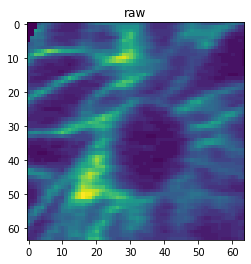

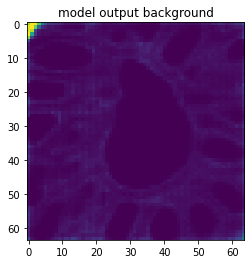

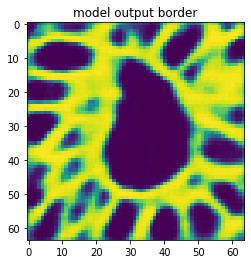

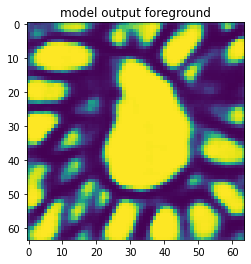

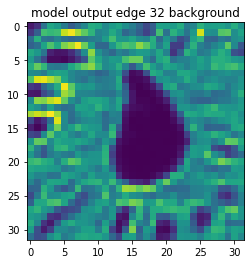

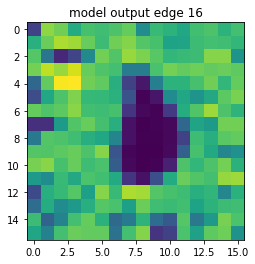

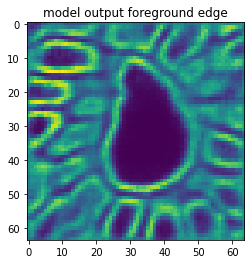

In [8]:
plt.figure()
plt.title("raw")
plt.imshow(test_img_cropped[:,50,:])

plt.figure()
plt.title("model output background")
plt.imshow(output_model[0,0,:,32,:])

plt.figure()
plt.title("model output border")
plt.imshow(output_model[0,1,:,32,:])

plt.figure()
plt.title("model output foreground")
plt.imshow(output_model[0,2,:,32,:])


plt.figure()
plt.title("model output edge 32 background")
plt.imshow(output_32[0,2,:,16,:])
"""
plt.figure()
plt.title("model output edge 32 border")
plt.imshow(output_32[0,1,:,16,:])

plt.figure()
plt.title("model output edge 32 foreground")
plt.imshow(output_32[0,2,:,16,:])
"""


plt.figure()
plt.title("model output edge 16")
plt.imshow(output_16[0,2,:,8,:])



plt.figure()
plt.title("model output foreground edge")
plt.imshow(output_edge[0,2,:,32,:])





In [ ]:


background_mask = np.load('data/CellSeg_dataset/HMS_processed/segmentation/135/135_background_3d_mask.npy')
foreground_mask = np.load('data/CellSeg_dataset/HMS_processed/segmentation/135/135_foreground_3d_mask.npy')
boundary_mask = np.load('data/CellSeg_dataset/HMS_processed/segmentation/135/135_boundary_3d_mask.npy')

background_mask_cropped = background_mask[60:124, 100:164, 40:104]
foreground_mask_cropped = foreground_mask[60:124, 100:164, 40:104]
boundary_mask_cropped = boundary_mask[60:124, 100:164, 40:104]

plt.figure()
plt.title("raw")
plt.imshow(test_img_cropped[:,50,:])

plt.figure()
plt.title("groundtruth background")
plt.imshow(background_mask_cropped[:,50,:])

plt.figure()
plt.title("groundtruth border")
plt.imshow(boundary_mask_cropped[:,50,:])

plt.figure()
plt.title("groundtruth foreground")
plt.imshow(foreground_mask_cropped[:,50,:])

In [ ]:
background_mask_cropped = torch.from_numpy(background_mask_cropped)
boundary_mask_cropped = torch.from_numpy(boundary_mask_cropped)
foreground_mask_cropped = torch.from_numpy(foreground_mask_cropped)


# background_mask_cropped = torch.unsqueeze(background_mask_cropped, 0)
# boundary_mask_cropped = torch.unsqueeze(boundary_mask_cropped, 0)
# foreground_mask_cropped = torch.unsqueeze(foreground_mask_cropped, 0)

gt_mask = torch.stack([background_mask_cropped, boundary_mask_cropped, foreground_mask_cropped], dim=0)
gt_mask = torch.unsqueeze(gt_mask, 0)

In [ ]:
gt_mask.shape

In [ ]:
import torch.nn.functional as F

gt_mask_32 = F.interpolate(gt_mask, size=(32, 32, 32))
gt_mask_16 = F.interpolate(gt_mask_32, size=(16, 16, 16))
gt_mask_8 = F.interpolate(gt_mask_16, size=(8, 8, 8))
gt_mask_8_alt = F.interpolate(gt_mask, size=(8, 8, 8))

In [ ]:
plt.figure()
plt.title("gt_mask background")
plt.imshow(gt_mask[0,0,:,32,:])

plt.figure()
plt.title("gt_mask border")
plt.imshow(gt_mask[0,1,:,32,:])

plt.figure()
plt.title("model output foreground")
plt.imshow(gt_mask[0,2,:,32,:])


plt.figure()
plt.title("gt_mask background 32")
plt.imshow(gt_mask_32[0,0,:,16,:])

plt.figure()
plt.title("gt_mask border 32")
plt.imshow(gt_mask_32[0,1,:,16,:])

plt.figure()
plt.title("gt_mask foreground 32")
plt.imshow(gt_mask_32[0,2,:,16,:])


plt.figure()
plt.title("gt_mask background 16")
plt.imshow(gt_mask_16[0,0,:,8,:])

plt.figure()
plt.title("gt_mask border 16")
plt.imshow(gt_mask_16[0,1,:,8,:])

plt.figure()
plt.title("gt_mask foreground 16")
plt.imshow(gt_mask_16[0,2,:,8,:])


plt.figure()
plt.title("gt_mask background 8")
plt.imshow(gt_mask_8[0,0,:,4,:])

plt.figure()
plt.title("gt_mask border 8")
plt.imshow(gt_mask_8[0,1,:,4,:])

plt.figure()
plt.title("gt_mask foreground 8")
plt.imshow(gt_mask_8[0,2,:,4,:])


plt.figure()
plt.title("gt_mask background 8 alternative")
plt.imshow(gt_mask_8_alt[0,0,:,4,:])

plt.figure()
plt.title("gt_mask border 8 alternative")
plt.imshow(gt_mask_8_alt[0,1,:,4,:])

plt.figure()
plt.title("gt_mask foreground 8 alternative")
plt.imshow(gt_mask_8_alt[0,2,:,4,:])